In [316]:
import torch
print("torch module path:", torch.__file__)
print(torch.cuda.is_available())
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, log_loss

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
import numpy as np



torch module path: c:\Users\Daria\anaconda3\Lib\site-packages\torch\__init__.py
False


In [298]:

data = pd.read_csv('Data/Final_data/final_depr_one_scaled_2')

data = data.iloc[:, 1:]
data.head()

,821,328813,823,817,818,239935,28116,351091,28118,1161942,...,78344,1692,68274,40091,1393,28133,183,29346,349096,Depression
0,0.224972,0.002162,0.001842,0.000801,0.002563,0.000080,0.038603,0.002723,0.002403,0.000000,...,0.0,0.0,0.0,0.00008,0.0,0.0,0.0,0.000000,0.00008,0
1,0.009963,0.000082,0.018865,0.000082,0.003022,0.005063,0.006370,0.018375,0.000408,0.034953,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,1
2,0.131690,0.018601,0.000093,0.005562,0.013163,0.009362,0.215486,0.009795,0.002101,0.000185,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000031,0.00000,0
3,0.106448,0.003627,0.002877,0.000375,0.021202,0.000063,0.039402,0.060479,0.000751,0.000125,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0
4,0.175204,0.003135,0.010005,0.003919,0.018581,0.020932,0.045184,0.012679,0.004611,0.002674,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,1


In [ ]:
class TabularTransformer(nn.Module):
    def __init__(self, input_dim=556, embed_dim=64, num_heads=4, hidden_dim=128, num_layers=2, seq_len=139):
        super().__init__()
        self.seq_len = seq_len
        self.dim_per_token = input_dim // seq_len

        self.input_projection = nn.Linear(self.dim_per_token, embed_dim)
        self.position_embedding = nn.Parameter(torch.randn(seq_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x: [batch_size, input_dim]
        x = x.view(-1, self.seq_len, self.dim_per_token)  # [B, S, D]
        x = self.input_projection(x) + self.position_embedding  # Add positional encoding
        x = self.transformer(x)
        x = x.mean(dim=1)  # [B, E]
        logits = self.classifier(x).squeeze(-1)
        return logits


In [300]:
class SklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=556, model_class=TabularTransformer, lr=0.001, epochs=100, batch_size=32,
                 model_embed_dim=64, model_num_layers=2, model_num_heads=4, model_hidden_dim=128,
                 model_seq_len=139, device='cpu'):
        self.input_dim = input_dim
        self.model_class = model_class
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

        # Store model hyperparameters
        self.model_embed_dim = model_embed_dim
        self.model_num_layers = model_num_layers
        self.model_num_heads = model_num_heads
        self.model_hidden_dim = model_hidden_dim
        self.model_seq_len = model_seq_len

        self._build_model()

    def _build_model(self):
        self._net = self.model_class(
            input_dim=self.input_dim,
            embed_dim=self.model_embed_dim,
            num_layers=self.model_num_layers,
            num_heads=self.model_num_heads,
            hidden_dim=self.model_hidden_dim,
            seq_len=self.model_seq_len
        )
        self._net.to(self.device)

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        optimizer = torch.optim.Adam(self._net.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self._net.train()
        for epoch in range(self.epochs):
            for xb, yb in loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad()
                logits = self._net(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()
        return self

    def predict_proba(self, X):
        X = check_array(X)
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        self._net.eval()
        with torch.no_grad():
            logits = self._net(X)
            probs = torch.sigmoid(logits).cpu().numpy()
            return np.vstack([1 - probs, probs]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)


In [ ]:
param_grid = {
        'lr': [0.001, 0.0001], #
        'epochs': [100, 150, 200, 250],#,
        'batch_size': [32, 64],
        'model_embed_dim': [32, 64],
    }

In [ ]:
X = data.drop('Depression', axis = 1)
y = data['Depression']

X = X.values
y = y.values

In [ ]:

nested_scores = []
data_X = data.drop('Depression', axis = 1)
feature_names = data_X.columns.tolist()
N = 60
all_fprs = []
all_tprs = []
roc_auc_scores = []
top_features_per_fold = []

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in outer_cv.split(X, y):
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_test_cv = X[test_idx]
    y_test_cv = y[test_idx]

    scaler = StandardScaler()
    X_train_cv = scaler.fit_transform(X_train_cv)
    X_test_cv = scaler.fit_transform(X_test_cv)

    X_train_cv = torch.FloatTensor(X_train_cv)
    y_train_cv = torch.LongTensor(y_train_cv)
    X_test_cv = torch.FloatTensor(X_test_cv)
    

    base = SklearnWrapper(input_dim=X.shape[1])

    clf = GridSearchCV(estimator=base, param_grid=param_grid, cv=3, scoring='accuracy', refit=True, verbose=0)
    clf.fit(X_train_cv, y_train_cv)

    y_proba = clf.best_estimator_.predict_proba(X_test_cv)[:, 1]
    y_pred = clf.best_estimator_.predict(X_test_cv)

    auc = roc_auc_score(y_test_cv, y_proba)
    acc = accuracy_score(y_test_cv, y_pred)

    cm = confusion_matrix(y_test_cv, y_pred)
    print("Confusion Matrix:")
    print(cm)

    roc_auc_scores.append(auc)
    nested_scores.append(acc)  

    fpr, tpr, _ = roc_curve(y_test_cv, y_proba)
    all_fprs.append(fpr)
    all_tprs.append(tpr)

    #best_estimator_.

    with torch.no_grad():
        input_proj_weights = clf.best_estimator_._net.input_projection.weight.detach().cpu().numpy()
    
        token_feature_importance = np.mean(np.abs(input_proj_weights), axis=0)  # shape (4,)
        feature_importance = np.tile(token_feature_importance, clf.best_estimator_._net.seq_len)  # shape (556,)
        
        top_feature_indices = np.argsort(feature_importance)[::-1][:N]
        top_feature_names = [feature_names[i] for i in top_feature_indices]

    #print("Top feature indices:", top_feature_indices)
    print("Top feature names:", top_feature_names)
    top_features_per_fold.append(top_feature_names)   

    print(f"Fold ROC AUC: {auc:.4f} | Accuracy: {acc:.4f}")

print(f"Nested CV Mean Accuracy: {np.mean(nested_scores):.4f}")


Confusion Matrix:
[[32 11]
 [ 6 38]]
Top feature names: ['349096', '28130', '472113', '84109', '1304158', '626935', '1502', '1717', '29360', '701529', '47246', '574375', '341694', '871327', '28134', '332249', '180164', '363277', '1527', '36849', '1077256', '133926', '1304', '1680', '626931', '39778', '1566358', '37734', '1402', '281920', '290055', '1336', '264463', '29347', '1590', '1177728', '831', '28123', '42256', '1113650', '58138', '1134405', '574930', '66851', '28125', '45254', '38986', '88431', '358743', '187145', '45851', '29389', '863', '1776082', '1519', '74426', '341220', '316', '564835', '762210']
Fold ROC AUC: 0.8874 | Accuracy: 0.8046
Confusion Matrix:
[[43  4]
 [ 4 36]]
Top feature names: ['881', '1113741', '1735', '658457', '1541', '35785', '1491', '43997', '1168034', '582', '39491', '33905', '253245', '990', '930124', '1544', '2741', '1267', '43675', '882211', '1501', '1630', '38284', '282402', '488', '1694', '290053', '386414', '84032', '40215', '39486', '28128', '762

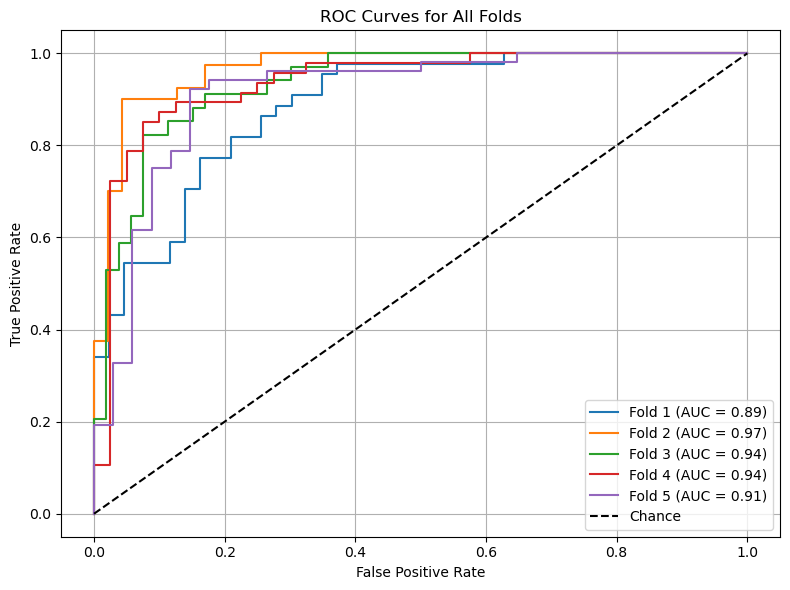

In [313]:
plt.figure(figsize=(8, 6))
for i in range(len(all_fprs)):
    plt.plot(all_fprs[i], all_tprs[i], label=f'Fold {i+1} (AUC = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Folds')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [314]:
print(clf.best_estimator_)

SklearnWrapper(epochs=200, model_embed_dim=32)


In [317]:
def features_in_k_arrays(arrays, k):
    if not arrays:
        return []

    counter = Counter()
    
    for array in arrays:
        unique_strings = set(array)  
        counter.update(unique_strings)
    
    return [string for string, count in counter.items() if count >= k]

In [320]:

k=5
common_features = features_in_k_arrays(arrays, k)
print(f"\nFeatures appearing in at least {k} folds: {common_features} \n total length: {len(common_features)}")
k=4
common_features = features_in_k_arrays(arrays, k)
print(f"\nFeatures appearing in at least {k} folds: {common_features} \n total length: {len(common_features)}")

k=3
common_features = features_in_k_arrays(arrays, k)
print(f"\nFeatures appearing in at least {k} folds: {common_features} \n total length: {len(common_features)}")



Features appearing in at least 5 folds: [] 
 total length: 0

Features appearing in at least 4 folds: [] 
 total length: 0

Features appearing in at least 3 folds: [] 
 total length: 0


In [310]:
#m = clf.best_state_dict

In [311]:
best_model = clf.best_estimator_